# DEA Land Cover change mapping <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Background 

Land cover is the observed physical cover on the Earth's surface, including trees, shrubs, grasses, soils, exposed rocks, water bodies, plantations, crops and built structures. 
Land cover changes for many reasons, including seasonal weather, severe weather events such as cyclones, floods and fires, and human activities such as mining, agriculture and urbanisation. 
We can use change mapping techniques to quantify how much these processes influence land cover. 

## Description 

This notebook will demonstrate how to create a change map using [DEA Land Cover](https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat) data. Topics include: 

1. Loading data for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map using layer descriptor data. 

This notebook requires a basic understanding of the DEA Land Cover data set. If you are new to the DEA Land Cover data set, it is recommended you look at the [DEA Land Cover beginners notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages and connect to the datacube
Load key Python packages and supporting functions for the analysis, then connect to the datacube. 


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(1, os.path.abspath('../../Tools'))
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours
from dea_tools.land_cover import plot_land_cover

In [2]:
dc = datacube.Datacube(app='DEA_Land_Cover')

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Werribee, Victoria.

In [3]:
# Define area of interest and buffer values 
lat, lon = (-37.9, 144.7)

lat_buffer = 0.02
lon_buffer = 0.02

# Combine central coordinates with buffer to get area of intest 
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Set the range of dates for the analysis
time_range = ('2010', '2020')

The following cell will display the selected area on an interactive map. You can zoom in and out to better understand the area you'll be analysing. 

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view `level3` data 
The following cell will load `level3` data for the `lat_range`, `lon_range` and `time_range` we defined above.

In [5]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above.
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(product='ga_ls_landcover_class_cyear_2',
             output_crs='EPSG:3577',
             measurements=['level3'],
             resolution=(25, -25),
             **query)

We can use the `plot_land_cover()` function to look at the data for each year between 2010 and 2020.

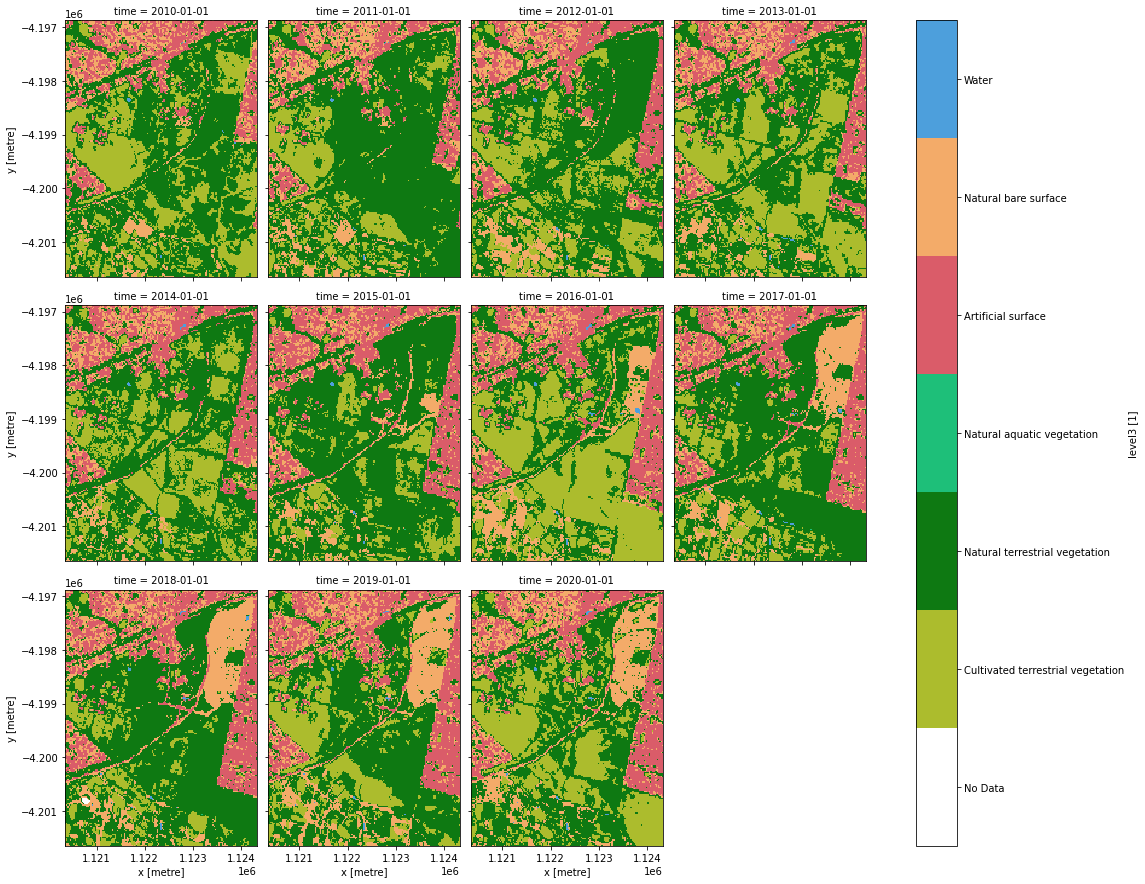

In [6]:
plot_land_cover(lc.level3)

As we can see, the dominant land cover types in this area are natural bare surface, artificial surface, and natural and cultivated vegetation. 
Between 2010 and 2020, artificial surface and natural bare has increased in area, and natural and cultivated vegetation has fluxuated. 

Now that we have an overview of the land cover conditions in this area, we can create some change maps!

## Plotting change maps

### Plotting overall change

In this section we will create a plot that shows whether a pixel changed class or remained the same between 2 selected years. In this example, we are using 2010 and 2020.


In [7]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = True

In [8]:
# Combine classifications from start & end dates
change_vals = ((start * 1000) + end)

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    out_change = np.where(start == end, 0, change_vals)

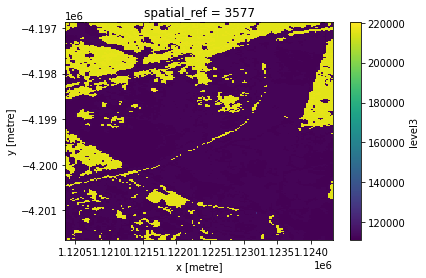

In [9]:
# Plot the change data
change_vals.plot()

### Plotting change maps for specific classes

In this section we will plot two change maps using natural terrestrial vegetation (NTV) data and artificial surfaces data.

#### Natural terrestrial vegetation change

In [10]:
# Make a mask of 1 for all increasing natural terrestrial vegetation (NTV)
# that is anything going from another class to NTV
NTV_increase = np.where(((out_change == 111112) |
                                (out_change == 124112) |
                                (out_change == 215112) |
                                (out_change == 216112) |
                                (out_change == 220112)),
                               1, 0)

In [11]:
# Make a mask of -1 for all decreasing natural terrestrial vegetation (NTV)
# that is anything going from NTV to another class
NTV_decrease = np.where(((out_change == 112111) |
                                (out_change == 112124) |
                                (out_change == 112215) |
                                (out_change == 112216) |
                                (out_change == 112220)),
                               -1, 0)

In [12]:
NTV_change = NTV_increase + NTV_decrease

In [13]:
# Create a new Xarray.DataArray, so we can plot
xr_ntvchange = xr.DataArray(data=NTV_change, 
             coords=change_vals.coords, 
             dims=change_vals.dims, name="ntv_change", 
             attrs=None, indexes=change_vals.indexes, fastpath=False)

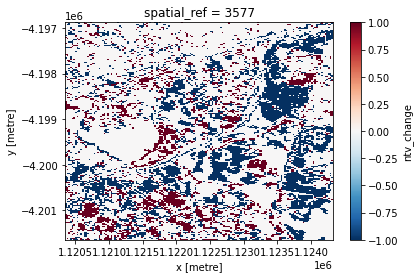

In [14]:
xr_ntvchange.plot.imshow()

#### Urban expansion

In [15]:
# Make a mask of 1 for all increasing artificial surfaces (AS)
AS_increase = np.where(((out_change == 111215) |
                                (out_change == 112215) |
                                (out_change == 124215) |
                                (out_change == 216215) |
                                (out_change == 220215)),
                               1, 0)

In [16]:
# Make a mask of -1 for all decreasing artificial surfaces (AS)
AS_decrease = np.where(((out_change == 215111) |
                                (out_change == 215112) |
                                (out_change == 215124) |
                                (out_change == 215216) |
                                (out_change == 215220)),
                               -1, 0)

In [17]:
AS_change = AS_increase + AS_decrease

In [18]:
# Create a new Xarray.DataArray, so we can plot
xr_aschange = xr.DataArray(data=AS_change, 
             coords=change_vals.coords, 
             dims=change_vals.dims, name="as_change", 
             attrs=None, indexes=change_vals.indexes, fastpath=False)

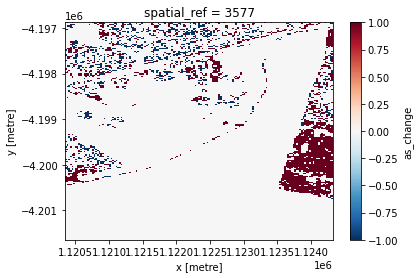

In [19]:
xr_aschange.plot.imshow()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2021

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)